# Predicting whether the cancer is benign or malignant using the Wisconsin Diagnostic Breast Cancer Dataset

[![GitHub](https://img.shields.io/badge/GitHub-View%20on%20GitHub-blue?logo=github)](https://github.com/denpalrius/AI-Machine-Learning-Practice/blob/main/svm/breast_cancer_svm.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/denpalrius/AI-Machine-Learning-Practice/blob/main/svm/breast_cancer_svm.ipynb)

## Introduction

**Dataset**: Breast Cancer Wisconsin (Diagnostic)  
**Source**: UCI Machine Learning Repository  

***Description***
- The Breast Cancer Wisconsin dataset contains medical information about breast tumors, aiming to classify them as benign or malignant. 
- The features describe characteristics of the tumor cells, such as radius, texture, perimeter, and more. 
- The goal is to predict whether a tumor is malignant (cancerous) or benign (non-cancerous).

***Purpose***

To develop predictive models that can accurately diagnose breast cancer based on medical attributes, helping clinicians make informed decisions.


**Structure**
- Rows: 569
- Columns: 32
  - 30 feature columns (ID and 30 medical attributes)
  - 1 target column (diagnosis)

**Data Types**
- ID: integer
- Medical attributes: real numbers
- Diagnosis: categorical (Benign/Malignant)

**Target Variable**
- Diagnosis (column name: 'diagnosis')

**Target Values:**
- Benign (B)
- Malignant (M)

**Missing Values**
- The raw dataset contains missing values for various rows

**Class distribution** 
- 357 benign
- 212 malignant

In [351]:
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve,  roc_curve, auc

## Load the Data

### Reading the data from the CSV

In [292]:
data = pd.read_csv('data/wdbc-raw.csv')

Colum names for the data

In [293]:
columns = [
    'id',                        # 1) ID number
    'diagnosis',                 # 2) Diagnosis (M = malignant, B = benign)
    'radius_mean',               # 3) radius (mean of distances from center to points on the perimeter)
    'texture_mean',              # 4) texture (standard deviation of gray-scale values)
    'perimeter_mean',            # 5) perimeter
    'area_mean',                 # 6) area
    'smoothness_mean',           # 7) smoothness (local variation in radius lengths)
    'compactness_mean',          # 8) compactness (perimeter^2 / area - 1.0)
    'concavity_mean',            # 9) concavity (severity of concave portions of the contour)
    'concave_points_mean',       # 10) concave points (number of concave portions of the contour)
    'symmetry_mean',             # 11) symmetry
    'fractal_dimension_mean',    # 12) fractal dimension ("coastline approximation" - 1)
    'radius_se',                 # 13) radius (standard error)
    'texture_se',                # 14) texture (standard error)
    'perimeter_se',              # 15) perimeter (standard error)
    'area_se',                   # 16) area (standard error)
    'smoothness_se',             # 17) smoothness (standard error)
    'compactness_se',            # 18) compactness (standard error)
    'concavity_se',              # 19) concavity (standard error)
    'concave_points_se',         # 20) concave points (standard error)
    'symmetry_se',               # 21) symmetry (standard error)
    'fractal_dimension_se',      # 22) fractal dimension (standard error)
    'radius_worst',              # 23) radius (worst value)
    'texture_worst',             # 24) texture (worst value)
    'perimeter_worst',           # 25) perimeter (worst value)
    'area_worst',                # 26) area (worst value)
    'smoothness_worst',          # 27) smoothness (worst value)
    'compactness_worst',         # 28) compactness (worst value)
    'concavity_worst',           # 29) concavity (worst value)
    'concave_points_worst',      # 30) concave points (worst value)
    'symmetry_worst',            # 31) symmetry (worst value)
    'fractal_dimension_worst'    # 32) fractal dimension (worst value)
]

data.columns = columns

Reviewing the first few rows of the data

In [294]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842517,M,200.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,NaN,130.00,1203.0,NaN,NaN,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,NaN,NaN,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


### Configure Features and Lables

In [295]:
X = data.drop(['id', 'diagnosis'], axis=1)

**Binary Encoding**

The `diagnosis` column is a categorical variable, so we will perform binary encoding as SVM needs numerical data for target input.

M = 1 for malignant and B = 0 for benign

In [296]:
Y = data['diagnosis'].map({'M': 1, 'B': 0})

pd.DataFrame(Y, columns=['diagnosis']).head()

,diagnosis
0,1
1,1
2,1
3,1
4,1


### Handling Missing Data

Check for missing values

In [337]:
null_values = X.isnull().sum()

print(f'There are {null_values.sum()} missing values in the dataset\n')
print(null_values[null_values > 0])

There are 37 missing values in the dataset

texture_mean              1
perimeter_mean            1
area_mean                 1
smoothness_mean           1
compactness_mean          1
concavity_mean            3
concave_points_mean       1
symmetry_mean             1
fractal_dimension_mean    2
radius_se                 1
texture_se                5
perimeter_se              4
smoothness_se             4
compactness_se            3
concave_points_se         3
fractal_dimension_se      2
perimeter_worst           3
dtype: int64


**Visualizing the data distributions to determine the best imputation strategy**

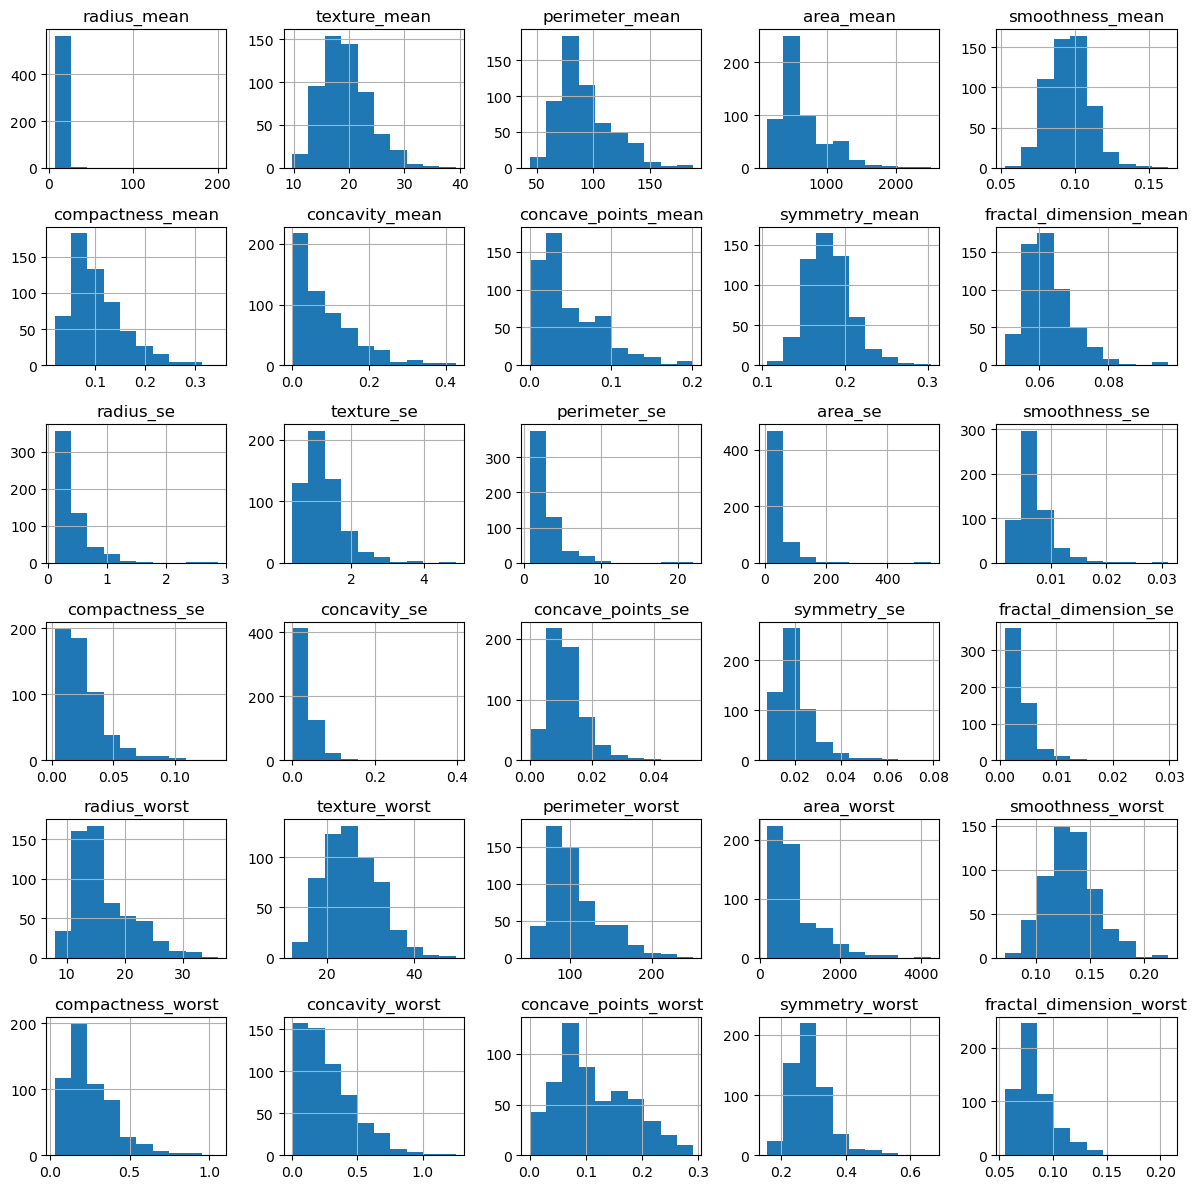

In [298]:
X.hist(figsize=(12, 12))
plt.tight_layout()
plt.show()

***Distribution Insights:***
- Most features show right-skewed distributions
- There are very few missing values (1-5 per feature)
- Features can be grouped into related sets:
    - Geometric (radius, area, perimeter)
    - Texture-based
    - Shape-based (concavity, symmetry)

***Median Imputation*** would be most appropriate here because:
- It is robust to the obvious right-skewed nature of most features
- Simple and transparent for medical data where interpretability is important
- With very few missing values (max 5 in any column), complex methods are unnecessary
- Median preserves the central tendency better than mean for these skewed distributions
- Won't introduce artificial relationships or complexity

***Why not other methods:***
- _Mean imputation_: Would be pulled by outliers in these skewed distributions
- _Mode imputation_: Unsuitable due to the continuous, non-categorical nature of most features
- _MICE/KNN_: Overly complex for such sparse missing data
- _Interpolation_: It assumes a smooth, continuous relationship between data points, which doesn't fit the non-sequential, skewed nature of this dataset
- _Row deletion_: Unnecessary given very few missing values

**Perform Median Imputation**

In [299]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

Preview the first 5 rows of the X_imputed dataframe to verify that the missing values have been imputed

In [300]:
print(f'There are now {X_imputed.isnull().sum().sum()} missing values in the dataset')

pd.concat([X_imputed, Y], axis=1).head()

There are now 0 missing values in the dataset


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,200.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
1,19.69,18.84,130.00,1203.0,0.09586,0.09242,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
2,11.42,20.38,86.24,551.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
3,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1
4,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,1


## Model Evaluation Utilities

**Model Selection**

For Kernel selection:
- We will focus on `rbf` and `linear` kenernels because:
    - Radial Basis Function (RBF) Kernel is robust and effective for non-linear relationships.
    - Linear Kernel is simple and efficient for linearly separable data.

- `poly` and `sigmoid` are not good choices because:
    - The dataset is not linearly separable due to non-linear relationships shocased by the LDA results
    - Overlapping classes showcased by the PCA plots. There is no clear linear separation between classes
    - High-dimensional feature space (30)

**Validation set vs Cross-Validation**

Using a **validation set** will not provide any real benefits due to these reasons:
1. Splitting into train/validation/test would leave very few samples in each set, since this is a relatively small dataset. They will therefore not be enough for reliable model tuning
2. SVM has relatively few hyperparameters to tune. This is mainly C and kernel parameters

For this problem, **Cross-Validation** makes is preferrable for the following reasons:
1. Cross-validation uses the entire dataset for both training and validation, improving model performance by utilizing all available samples, hence maximising data usage.
2. It provides a more reliable estimate of model performance by averaging results over multiple data splits, hence reducing bias
3. We can make use of K-fold cross-validation for ***Model selection***, SVM ***Hyperparameter tuning*** without overfitting and ***Performance estimation***
4. We will have a more sizeable single test set for final evaluation

Function to perform a comprehensive SVM model evaluation with grid search, including a 5-fold cross-validation

In [301]:
def get_best_svm(X_train, Y_train, get_probabilities=True):
    pipeline = Pipeline([
        ('svm', SVC(random_state=42, probability=get_probabilities))
    ])

    # The hyperparameter grid
    param_grid = {
        "svm__kernel": ["linear", "rbf"], # Kernel type
        "svm__C": [0.1, 1, 10, 100], # Regularization parameter
        "svm__gamma": ["scale", "auto", 0.1, 0.01], # Kernel coefficient
    }

    start_time = time.time()
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", verbose=1)
    grid_search.fit(X_train, Y_train)

    print(f"\nModel selection (took {time.time() - start_time:.2f} seconds)")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

    best_svm = grid_search.best_estimator_
    return best_svm

Function to plot the confusion matrix

In [302]:
def plot_confusion_matrix(conf_matrix):
    target_names=['Benign', 'Malignant']

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,)
    
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Diagnosis')
    plt.xlabel('Predicted Diagnosis')
    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    
    plt.tight_layout()

    plt.show()

Function to display the precision-recall curve

In [303]:
def plot_precision_recall_curve(y_test, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    ap = average_precision_score(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP = {ap:.3f})')
    plt.show()

Function to plot the ROC curve

In [304]:
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    plt.grid(True, linestyle='--', alpha=0.5) # Gridlines for better readability
    
    plt.show()

Function to evaluate the model performance

In [353]:
def evaluate_model(svm_model, y_test, y_pred, y_pred_prob, X_train, X_test, y_train):
    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)

    report = classification_report(y_test, y_pred, target_names=['Benign', 'Malignant'])
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("\nModel Performance Metrics:")
    print("-" * 50)

    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")


    print("\nClassification Report:")
    print(report)

    print("\nConfusion Matrix:")
    plot_confusion_matrix(conf_matrix)
    print(conf_matrix)

    if y_pred_prob is not None:
        print("\nPrecision-Recall Curve:")
        plot_precision_recall_curve(y_test, y_pred_prob)

        print("\nROC Curve:")
        plot_roc_curve(y_test, y_pred_prob)


## Initial Training (Prior to Data Pre-processing)

Skip fetching probabilities for evaluation plots to speed up testing (Should be turned to True for final run)

In [306]:
get_probabilities = False

Splitting the dataset into training and test sets (80% train, 20% test)

In [307]:
X_train_pre, X_test_pre, Y_train_pre, Y_test_pre = train_test_split(X_imputed, Y, test_size=0.2, random_state=42)

Training the SVM classifier using best model and hyperparameters

In [308]:
initial_model = get_best_svm(X_train_pre, Y_train_pre, get_probabilities)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Model selection (took 67.48 seconds)
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best cross-validation score: 0.960


Making predictions on the test set

In [309]:
Y_pred_pre = initial_model.predict(X_test_pre)
y_pred_prob_pre = initial_model.predict_proba(X_test_pre)[:, 1] if get_probabilities else None

Evaluating model performance


Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 97.80%
Testing Accuracy: 91.23%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.91      0.94      0.93        68
   Malignant       0.91      0.87      0.89        46

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114


Confusion Matrix:


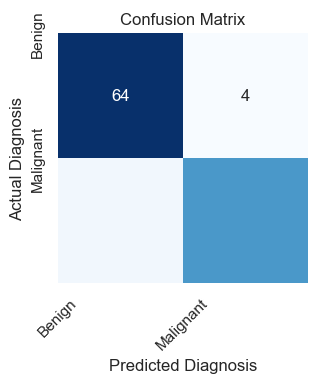

[[64  4]
 [ 6 40]]


In [357]:
evaluate_model(initial_model, Y_test_pre, Y_pred_pre, y_pred_prob_pre, X_train_pre, X_test_pre, Y_train_pre)

***Key Insights:***
- The model shows reasonably good performance with both accuracies above 87%
- The moderate gap (5%) between training and testing accuracy suggests mild overfitting, but nothing severe
- The model generalizes fairly well to unseen data, as the test accuracy remains strong

## Data visualizaton and Feature selection

#### Correlation matrix

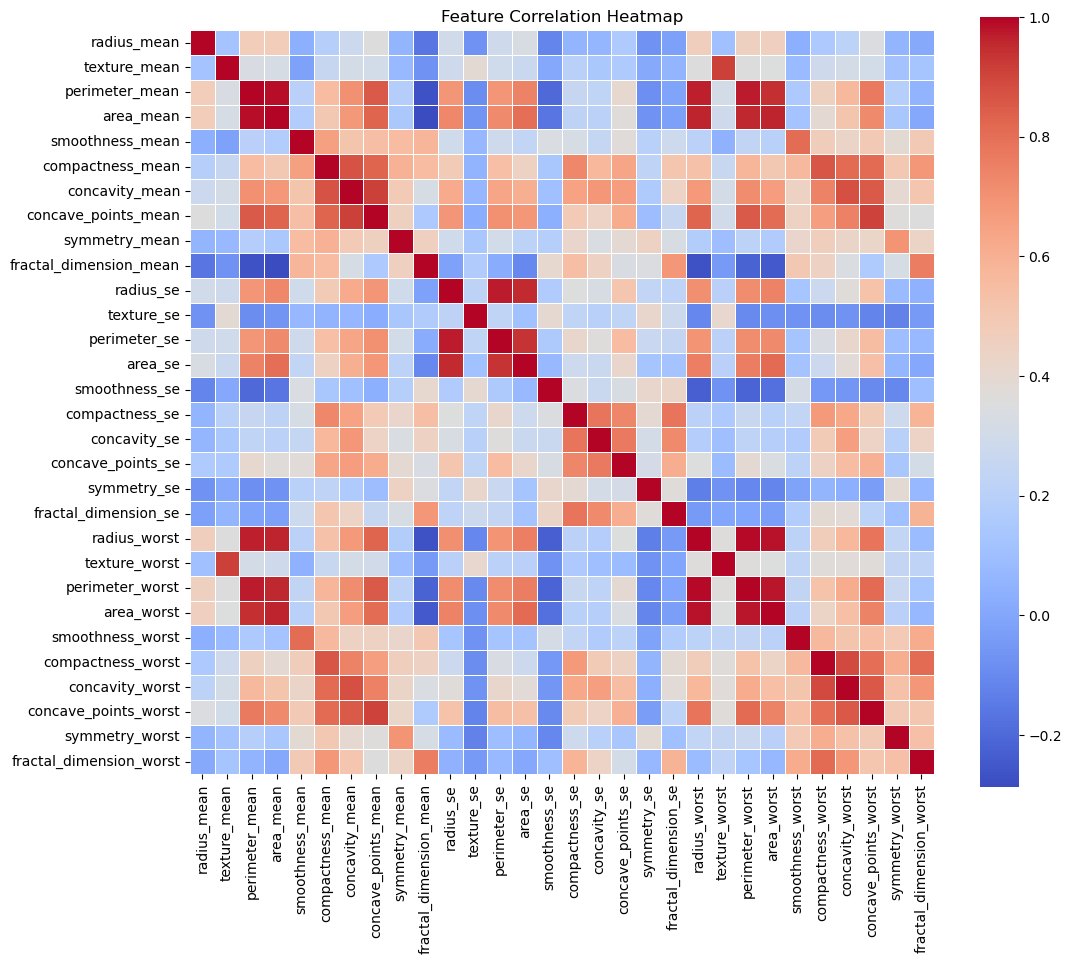

In [311]:
correlation_matrix = X_imputed.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

**Observations**:

1. ***Strong Feature Groupings:***
- There are strong correlations between `radius`, `perimeter`, and `area` measurements across all three categories (mean, SE, and worst), shown by the dark red squares. This makes sense geometrically as these are related measurements.
- `texture` features show moderate correlations with each other across the different measurement types (mean, SE, worst).

2. ***Concavity-Related Correlations:***
- `concavity`, `concave points`, and `compactness` show moderate to strong positive correlations with each other (shown in red/pink squares)
- This suggests these features describing the irregularity of cell shapes tend to vary together.

3. ***Measurement Types:***
- The "worst" measurements generally show stronger correlations with other features compared to their "mean" or "SE" counterparts
- Standard error (SE) measurements show weaker correlations overall (more light colors), suggesting they might capture different aspects of variability

4. ***Independent Features:***
- `fractal dimension` shows relatively weak correlations with most other features (mostly light blue/white colors)
- `Symmetry` also appears to be relatively independent of other features
- These more independent features might provide unique information for diagnosis

5. ***Potential Feature Selection Implications:***
- The more independent features like `fractal dimension` and `symmetry` might be important to retain as they capture unique aspects of the data
- We can eliminate these columns to reduce redundancy:
    - `perimeter_mean`: strongly correlated with `radius_mean` and `area_mean`
    - `perimeter_se`: strongly correlated with `radius_se` and `area_se`
    - `concavity_mean`: moderately correlated with `concave_points_mean` and `symmetry_mean`
    - `concavity_se`: moderately correlated with `concave_points_se` and `symmetry_se`



In [312]:
print("Original shape of X:", X_imputed.shape)

# Dropping the specified columns to reduce redundancy
columns_to_drop = [
    'perimeter_mean',     # Strongly correlated with radius_mean and area_mean
    'perimeter_se',       # Strongly correlated with radius_se and area_se
    'concavity_mean',     # Moderately correlated with concave_points_mean and symmetry_mean
    'concavity_se'        # Moderately correlated with concave_points_se and symmetry_se
]

X_reduced = X_imputed.drop(columns=columns_to_drop)

# Displaying the shape of the reduced X for reference
print("Reduced shape of X:", X_reduced.shape)

Original shape of X: (568, 30)
Reduced shape of X: (568, 26)


#### Pair Plot (Scatterplot Matrix)

Draw pair plot for only select features

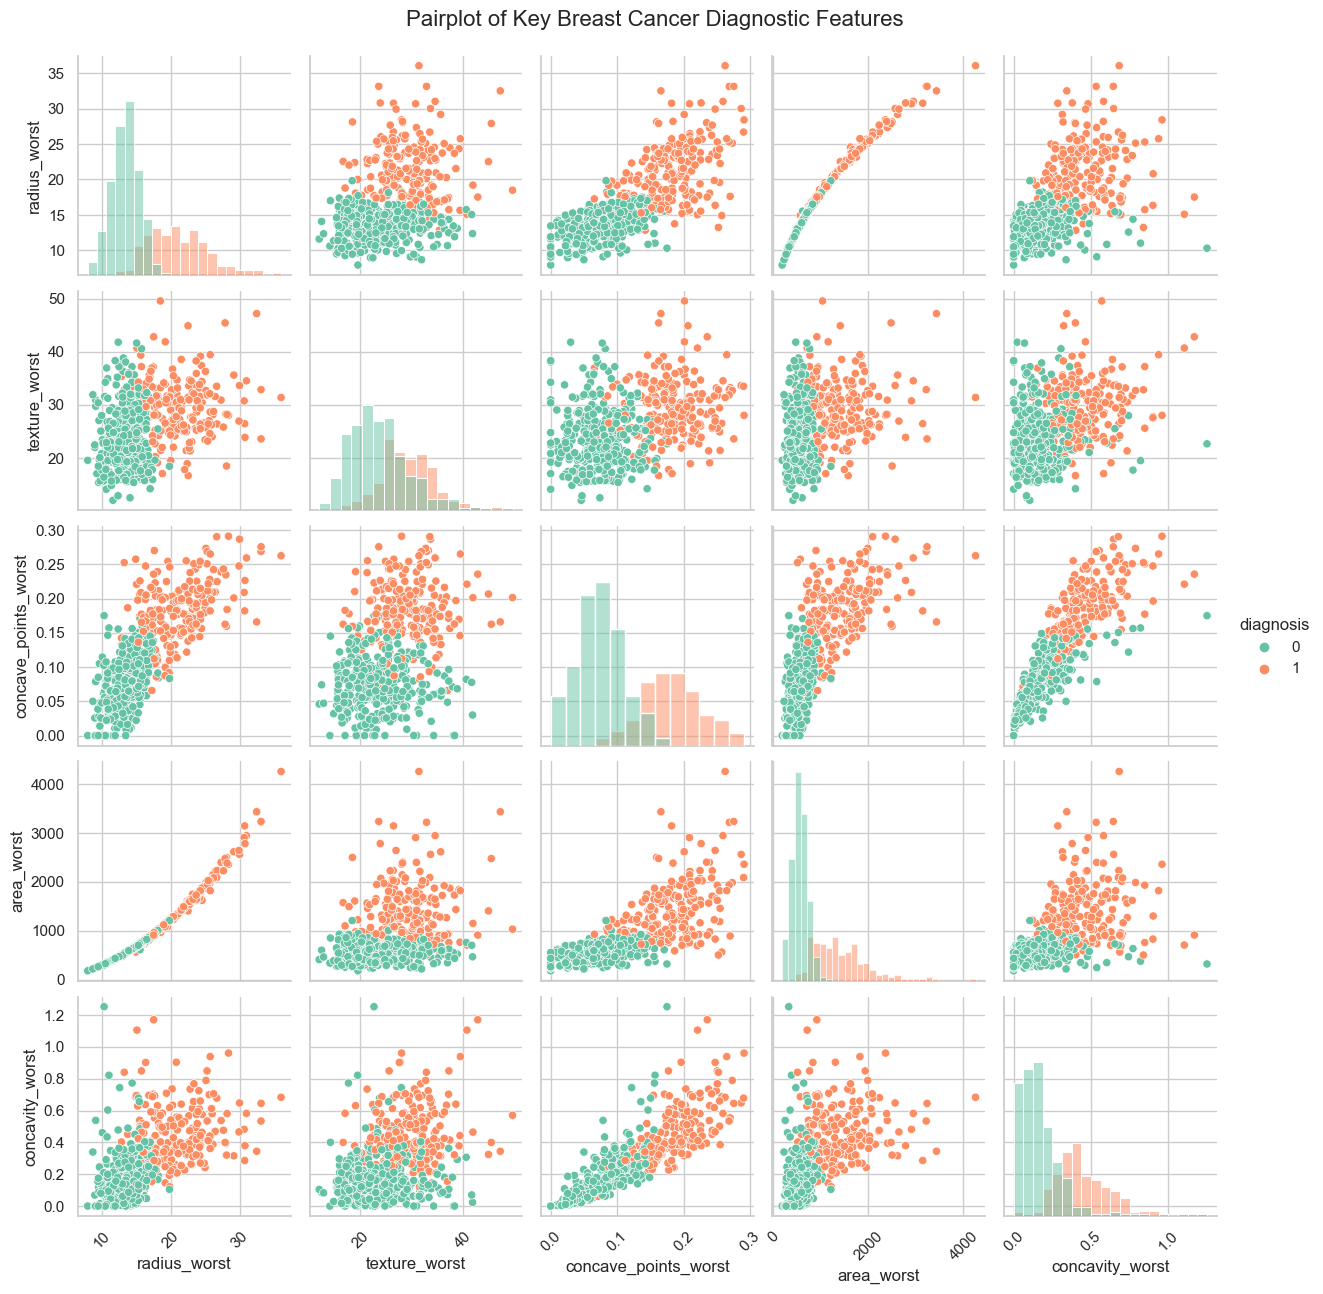

In [350]:
# Suppress specific FutureWarnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
        
    selected_features = ['radius_worst', 'texture_worst', 'concave_points_worst', 
                        'area_worst', 'concavity_worst']

    select_data = pd.DataFrame(X_reduced, columns=selected_features)
    select_data['diagnosis'] = Y

    select_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    select_data.dropna(inplace=True)

    sns.set_theme(style='whitegrid', palette='Set2')

    g = sns.pairplot(select_data, hue='diagnosis', diag_kind='hist', height=2.5)
    g.figure.suptitle('Pairplot of Key Breast Cancer Diagnostic Features', y=1.02, size=16)

    # Rotate x-axis labels for readability
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)

    plt.show()

**Key Insights**
- The Pairplot reveals strong positive correlations between `radius`, `texture`, and `concavity`
- There is clear separation between malignant and benign classes
- Non-linear relationships and outliers are present
- `Radius` and `texture` emerge as key features in distinguishing between classes

#### t-SNE Analysis

Function to perform t-SNE analysis

In [314]:
def perform_tsne(X, Y):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(8, 5))
    plt.scatter(X_tsne[Y == 0, 0], X_tsne[Y == 0, 1], label='Class 0 (Benign)', alpha=0.6)
    plt.scatter(X_tsne[Y == 1, 0], X_tsne[Y == 1, 1], label='Class 1 (Malignant)', alpha=0.6)
    plt.title('t-SNE Visualization of Breast Cancer Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Diagnosis', loc='best')
    plt.show()

Visualise 2D Scatter Plot using t-SNE

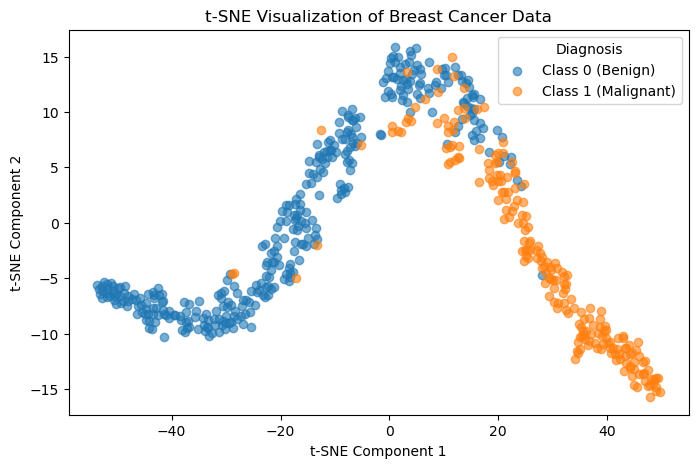

In [315]:
perform_tsne(X_reduced, Y)

**Key insights:**
- The two classes are clearly separable, indicating the features are informative for classification.
- Some overlap exists, suggesting possible misclassification in borderline cases. This could lead to some misclassification, as seen in the classification report where recall for malignant is slightly lower.
- Both benign and malignant data form well-defined clusters. Malignant cases appear more spread out compared to benign.
- A few outliers are visible, which may affect model performance. Outlier will need some careful handling.

#### Principal Component Analysis(PCA)


We can use PCA to check linear separability


In [316]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced)

Visualize separability for the first two principal components

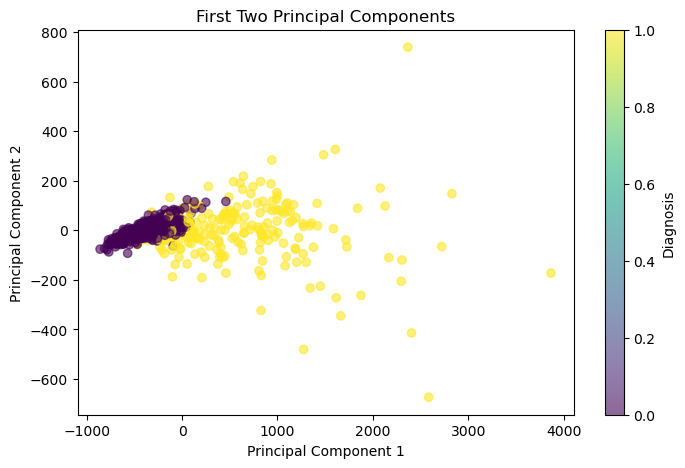

In [317]:
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', alpha=0.6)
plt.title('First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Diagnosis')
plt.show()

***Key Insights***
- Two clear clusters indicate potential class separation 
- The spread along the principal components indicates that these components capture significant variance in the dataset. 
- The variation between the clusters suggests that the features contributing to these components are meaningful in distinguishing the classes.
- Some isolated points suggest the presence of outliers, which may affect model performance.
- There is tight clustering indicating strong feature relationships, while wider spread suggests variability in the other cluster.

#### Linear Discriminant Analysis (LDA)

Function to plot LDA and ICA results

In [318]:
def plot_independent_components(X, Y, method, component_label):
    component_df = pd.DataFrame(data=X, columns=[component_label])
    component_df['Diagnosis'] = Y

    class_mapping = {0: 'Benign', 1: 'Malignant'}
    component_df['Diagnosis'] = component_df['Diagnosis'].map(class_mapping)

    plt.figure(figsize=(8, 5))
    plt.scatter(component_df[component_label][component_df['Diagnosis'] == 'Benign'], 
                [0] * len(component_df[component_df['Diagnosis'] == 'Benign']), 
                label='Class 0 (Benign)', alpha=0.6)
    plt.scatter(component_df[component_label][component_df['Diagnosis'] == 'Malignant'], 
                [1] * len(component_df[component_df['Diagnosis'] == 'Malignant']), 
                label='Class 1 (Malignant)', alpha=0.6)

    plt.title(f'{method.upper()} Visualization')
    plt.xlabel(component_label)
    plt.ylabel('Diagnosis')
    plt.legend(title='Diagnosis')
    plt.grid()
    plt.show()

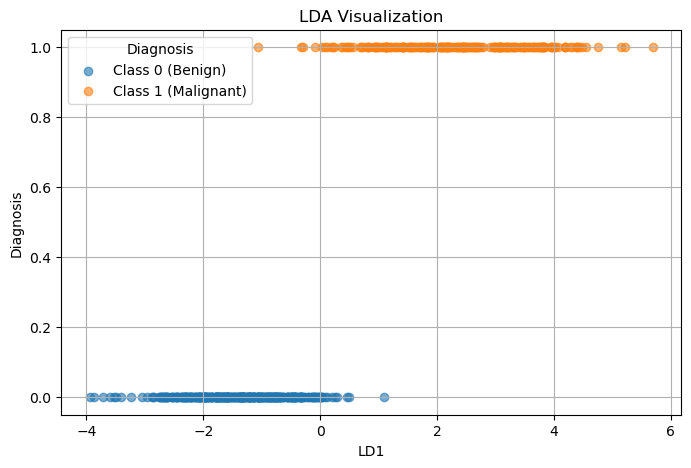

In [319]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_reduced, Y)

plot_independent_components(X_lda, Y, method='lda', component_label='LD1')

**Key Insights**
- There is a noticeable gap between the two classes, indicating a strong discriminative power of Linear Discriminant 1.
- The graph suggests that Linear Discriminant 1 is an effective feature for distinguishing between benign and malignant diagnoses.

#### Independent Component Analysis (ICA) 

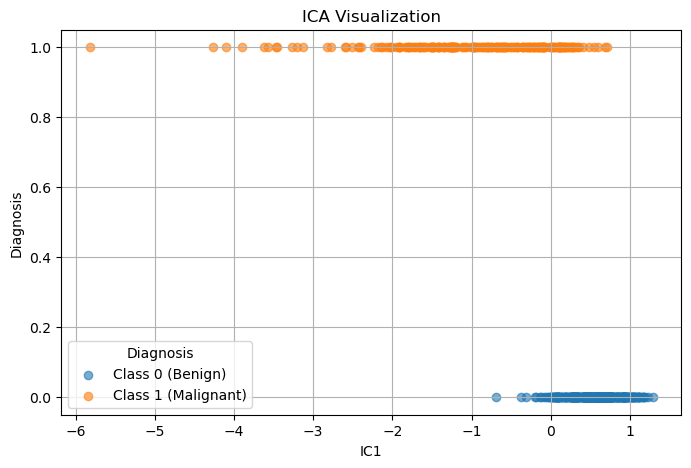

In [320]:
ica = FastICA(n_components=1, random_state=42)
X_ica = ica.fit_transform(X_reduced)

plot_independent_components(X_ica, Y, method='ica', component_label='IC1')

**Key Insights**
- The clear separation between Class 0 (Benign) and Class 1 (Malignant) along the IC1 axis suggests that ICA has successfully extracted a meaningful feature.
- The gap between the two classes indicates that IC1 can be used as a threshold to distinguish between benign and malignant diagnoses.

#### Singular Value Decomposition (SVD)

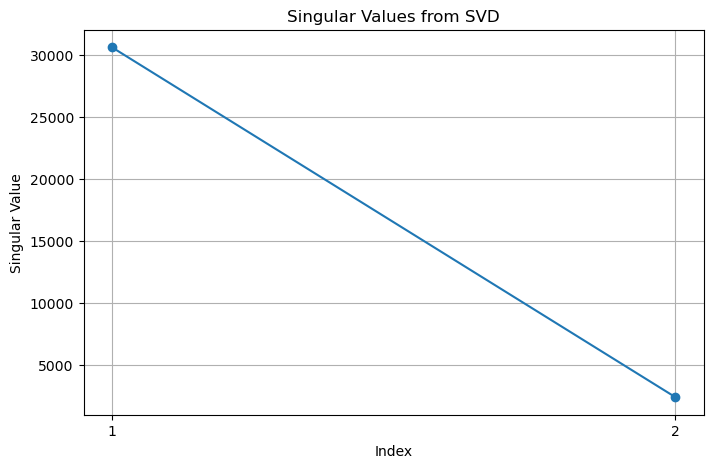

In [321]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_reduced)

singular_values = svd.singular_values_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o')
plt.title('Singular Values from SVD')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid()
plt.xticks(range(1, len(singular_values) + 1))
plt.show()

**Key Insights**
- The first singular value is approximately 30,000, while the second singular value is around 5,000.
- The ratio of the first to second singular value is about 6:1, indicating a strong dominance of the first singular vector.
- The steep decline in singular values suggests that the data may be well-represented by a low-rank approximation, with the first few singular vectors capturing most of the important information.

**Discussion on SVD for Dimensionality Reduction**

1. **Matrix Decomposition**: SVD decomposes a matrix \(A\) into \(U\), \(S\), and \(V^T\), capturing the data structure.

2. **Importance of Singular Values**: The diagonal values in \(S\) indicate variance; larger singular values correspond to more significant data features.

3. **Dimensionality Reduction**: Retaining only the top \(k\) singular values allows projection into a lower-dimensional space, preserving essential information while reducing noise and complexity.

4. **Applications**: SVD is used in image compression, natural language processing, and recommendation systems to maintain data integrity while simplifying analysis.

## Data transformations, Outlier Detection and Removal

**Log Transformation** - This will reduce skewness in features that have extreme values or long tails, making the data more normally distributed.

Features like `area_mean`, `perimeter_mean`, and `concavity_mean` are often skewed due to the nature of the data (e.g., size and shape of tumors).

The SVM model will perform better when features are normally distributed or closer to a Gaussian distribution. This transformation helps achieve that.

By reducing skewness, the transformed features become less sensitive to outliers, improving the classifier's ability to generalize.

In [322]:
X_transformed = X_reduced.apply(lambda x: np.log(x + 1) if x.skew() > 1 else x)
X_transformed.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,5.306137,17.77,7.190676,0.08474,0.075701,0.067818,0.1812,0.055122,0.434053,0.550373,...,3.257712,23.41,5.073923,7.579168,0.1238,0.171092,0.216401,0.1860,0.242946,0.085278
1,3.029650,18.84,7.093405,0.09586,0.088395,0.120357,0.2069,0.058259,0.557098,0.580482,...,3.201526,25.53,5.033701,7.444249,0.1444,0.353821,0.371839,0.2430,0.308440,0.083955
2,2.519308,20.38,6.313729,0.14250,0.249902,0.100026,0.2597,0.092980,0.402527,0.768255,...,2.766948,26.50,4.603869,6.343353,0.2098,0.623958,0.522893,0.2575,0.509104,0.159565
3,3.058237,14.34,7.168580,0.10030,0.124692,0.099212,0.1809,0.057165,0.563722,0.577343,...,3.158701,16.67,5.031744,7.362645,0.1374,0.186480,0.336472,0.1625,0.212204,0.073975
4,2.598979,15.70,6.169820,0.12780,0.157004,0.077785,0.2087,0.073371,0.288557,0.636683,...,2.801541,23.75,4.648230,6.610158,0.1791,0.421929,0.428856,0.1741,0.335400,0.117250


**Outlier Detection and Removal** - This will detect and remove extreme values using **IsolationForest**

In [323]:
def remove_outliers(X, Y, contamination=0.1):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)

    outlier_labels = iso_forest.fit_predict(X)

    # -1 indicates an outlier, 1 indicates an inlier
    inlier_mask = outlier_labels != -1

    # Keep only the inliers (i.e., non-outliers)
    X_cleaned = X[inlier_mask].reset_index(drop=True)
    Y_cleaned = Y[inlier_mask].reset_index(drop=True)

    print(f'Original number of samples: {len(X)}\n')
    print(f'Number of inliers: {len(X_cleaned)}')
    print(f'Number of outliers removed: {len(X) - len(X_cleaned)}\n')

    print(f'Shape of X_cleaned: {X_cleaned.shape}')
    print(f'Shape of Y_cleaned: {Y_cleaned.shape}')

    return X_cleaned, Y_cleaned

In [324]:
X_cleaned, Y_cleaned = remove_outliers(X_transformed, Y, contamination=0.1)

Original number of samples: 568

Number of inliers: 511
Number of outliers removed: 57

Shape of X_cleaned: (511, 26)
Shape of Y_cleaned: (511,)


**Standardization** - This will ensure that all features have a similar scale and contribute equally to the SVM model, which is highly sensitive to feature scaling.

In [325]:
X_standardized = StandardScaler().fit_transform(X_cleaned)
X_standardized = pd.DataFrame(X_standardized, columns=X_cleaned.columns)

X_standardized.head()

,radius_mean,texture_mean,area_mean,smoothness_mean,compactness_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,11.378154,-0.306292,1.927125,-0.824385,-0.408885,0.797081,0.130920,-0.926590,0.900526,-0.936757,...,1.904231,-0.334238,1.703454,1.936843,-0.337655,-0.355879,0.022983,1.289690,-0.188113,0.488922
1,1.470511,-0.044094,1.701954,0.065590,-0.073836,2.486721,1.225969,-0.322266,1.767752,-0.793538,...,1.666768,0.032009,1.548514,1.668516,0.653381,1.435433,1.159672,2.249226,1.459897,0.392109
2,1.594926,-1.146795,1.875975,0.420940,0.884167,1.806689,0.118138,-0.533200,1.814433,-0.808469,...,1.485772,-1.498627,1.540978,1.506223,0.316621,-0.205034,0.901039,0.894092,-0.961674,-0.338098
3,-0.403842,-0.813534,-0.436031,2.621869,1.736973,1.117619,1.302665,2.588908,-0.124927,-0.526213,...,-0.023734,-0.275500,0.063652,0.009675,2.322747,2.103103,1.576623,1.089366,2.138288,2.828187
4,1.156548,0.235257,1.365214,-0.032851,0.323736,0.911969,0.054224,-0.789905,0.444046,-0.830148,...,1.546379,0.399984,1.566040,1.544963,0.643759,0.213810,0.787334,1.410894,0.422148,0.129263


**Post-processing analysis using t-SNE**

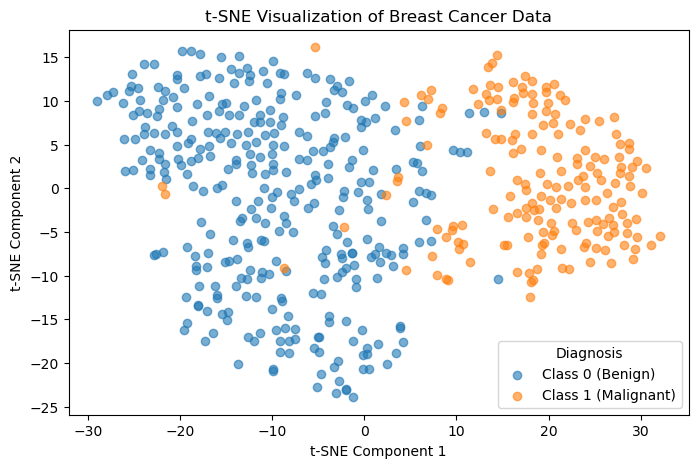

In [326]:
perform_tsne(X_standardized, Y_cleaned)

**Key Insights**
- After applying non-linear transformations (with log transformation), standardization, and median imputation for outliers, we  have a clearer separation of clusters in t-SNE plots. 
- The data is not over-processed, hence still likely to perform well for classification.

## Model Training (With Pre-processed Data)

Split the data into 80% training and 20% testing sets

In [327]:
X_train, X_test, Y_train, Y_test = train_test_split(X_standardized, Y_cleaned, test_size=0.2, random_state=42)

Training the SVM classifier using best model and hyperparameters, with 5-fold cross-validation

In [328]:
final_model = get_best_svm(X_train, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Model selection (took 1.07 seconds)
Best parameters: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best cross-validation score: 0.983


## Model Evaluation

Using the model to make predictions on the test set

In [359]:
Y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:, 1] if get_probabilities else None

Evaluating on the test set


Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 98.28%
Testing Accuracy: 98.06%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.98        64
   Malignant       1.00      0.95      0.97        39

    accuracy                           0.98       103
   macro avg       0.98      0.97      0.98       103
weighted avg       0.98      0.98      0.98       103


Confusion Matrix:


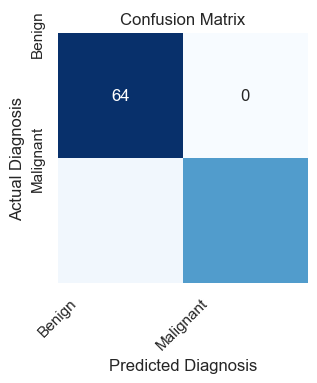

[[64  0]
 [ 2 37]]


In [360]:
evaluate_model(final_model, Y_test, Y_pred, y_pred_prob, X_train, X_test, Y_train)

## Comparison Model (Using RandomForestClassifier)

In [369]:
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X_standardized, Y_cleaned, test_size=0.2, random_state=42)

Function to get the best Random Forest model using GridSearchCV with 5-fold cross-validation

In [370]:
def get_best_rf_model(X_train_rf, Y_train_rf):
    param_grid_rf = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    }

    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
    grid_search_rf.fit(X_train_rf, Y_train_rf)

    print("Best RandomForest Parameters:", grid_search_rf.best_params_)
    print("Best RandomForest Accuracy:", grid_search_rf.best_score_)

    best_rf = grid_search_rf.best_estimator_
    return best_rf

Get the best Random Forest model

In [372]:
rf_model = get_best_rf_model(X_train_rf, Y_train_rf)

Best RandomForest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best RandomForest Accuracy: 0.9608250526949714


In [373]:
Y_pred_rf = rf_model.predict(X_test_rf)
y_pred_rf_prob = rf_model.predict_proba(X_test)[:, 1]


Model Performance Metrics:
--------------------------------------------------
Training Accuracy: 98.28%
Testing Accuracy: 98.06%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98        64
   Malignant       0.97      0.97      0.97        39

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103


Confusion Matrix:


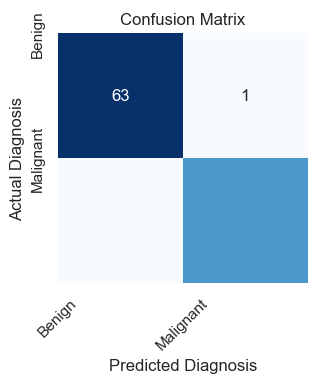

[[63  1]
 [ 1 38]]

Precision-Recall Curve:


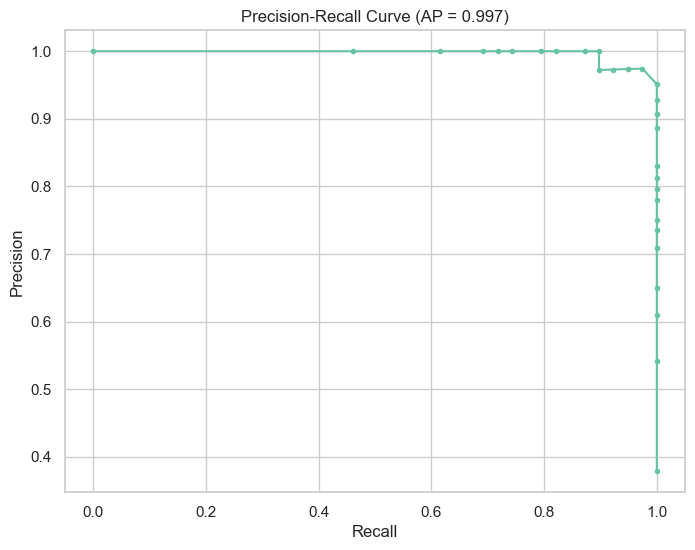


ROC Curve:


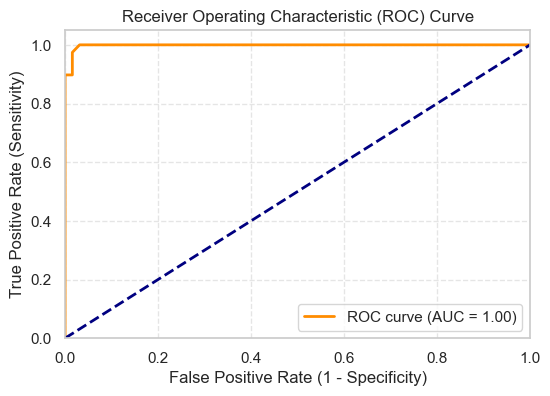

In [374]:
evaluate_model(final_model, Y_test_rf, Y_pred_rf, y_pred_rf_prob, X_train_rf, X_test_rf, Y_train_rf)

## Results Summary

Comparison of the SVM and Random Forest classifier results before and after data preprocessing:

| Metric                               | SVM (Before Preprocessing) | SVM (After Preprocessing) | Random Forest Classifier |
|--------------------------------------|----------------------------|---------------------------|---------------------------|
| **Training Accuracy**                | 97.80%                     | 98.28%                    | 98.28%                    |
| **Testing Accuracy**                 | 91.23%                     | 98.06%                    | 98.06%                    |
| **Classification Report**            |                            |                           |                           |
| **- Benign Precision**               | 0.91                       | 0.97                      | 0.98                      |
| **- Benign Recall**                  | 0.94                       | 1.00                      | 0.98                      |
| **- Benign F1-Score**                | 0.93                       | 0.98                      | 0.98                      |
| **- Malignant Precision**            | 0.91                       | 1.00                      | 0.97                      |
| **- Malignant Recall**               | 0.87                       | 0.95                      | 0.97                      |
| **- Malignant F1-Score**             | 0.89                       | 0.97                      | 0.97                      |
| **Overall Accuracy**                 | 0.91                       | 0.98                      | 0.98                      |
| **Macro Avg Precision**              | 0.91                       | 0.98                      | 0.98                      |
| **Macro Avg Recall**                 | 0.91                       | 0.97                      | 0.98                      |
| **Macro Avg F1-Score**               | 0.91                       | 0.98                      | 0.98                      |
| **Confusion Matrix**                 | [[64, 4],                  | [[64, 0],                | [[63, 1],                |
|                                      |  [6, 40]]                 |  [2, 37]]                |  [1, 38]]                |

### Insights:
1. **Performance Improvement**: 
   - The SVM model showed significant improvement in both training and testing accuracy after data preprocessing, increasing from 91.23% to 98.06%.
   - The Random Forest Classifier achieved comparable testing accuracy of 98.06%, indicating robust performance.

2. **Precision and Recall**:
   - The SVM model's precision and recall for the benign class improved from 0.91 and 0.94 to 0.97 and 1.00, respectively, indicating a perfect recall after preprocessing.
   - The malignant class also saw an increase in precision from 0.91 to 1.00, demonstrating enhanced classification capabilities.

3. **Confusion Matrices**:
   - The confusion matrices show a decrease in false positives and negatives for the SVM model after preprocessing, highlighting improved classification accuracy.
   - The Random Forest Classifier also maintained low confusion rates, reflecting its reliability.

### Conclusion:
Overall, data preprocessing significantly enhanced the SVM model's performance, achieving accuracy levels comparable to the Random Forest Classifier. Both models effectively differentiated between benign and malignant cases, with SVM showing particularly strong results post-preprocessing.